# Описание задачи

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

В ходе работы в пройдете все основные этапы полноценного исследования:

* загрузка и ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
np.set_printoptions(suppress = True)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.metrics import f1_score
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import xgboost as xgb
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#plt.style.use('dark_background') #раскомментируй, если у тебя темная тема

In [3]:
#pip install pandas-profiling
from ydata_profiling import ProfileReport

# Импорт и первичный обзор

In [4]:
df = pd.read_csv('/Users/artemmm/Downloads/music-genre-prediction-m124ds/kaggle_music_genre_train.csv')
df_test = pd.read_csv('/Users/artemmm/Downloads/music-genre-prediction-m124ds/kaggle_music_genre_test.csv')
sample_submit = pd.read_csv('/Users/artemmm/Downloads/music-genre-prediction-m124ds/sample_submit.csv')

Импорт файлов

In [5]:
df.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


Импортировалось успешно.

In [6]:
df.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

Есть пропуски.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

Некоторые типы столбцов не соответствуют заявленным.




# Предобработка данных

1. **ПРОПУСКИ**

In [8]:
print(df.shape[0])
df.isna().sum()

20394


instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

Столбцы имеют пропуски:
- key (базовый ключ произведения).
- mode (модальность (минор или мажор) трека).
- tempo (темп произведения).

In [9]:
print(df['mode'].value_counts(), '\n')
print(df['key'].value_counts(), '\n')
print(df['tempo'].value_counts(), '\n')

mode
Major    12828
Minor     7060
Name: count, dtype: int64 

key
G     2304
C     2149
C#    2125
D     2110
A     2013
F     1616
B     1522
E     1516
G#    1268
A#    1224
F#    1206
D#     606
Name: count, dtype: int64 

tempo
140.011    9
120.000    9
119.998    9
130.016    8
100.003    8
          ..
71.607     1
169.832    1
100.311    1
94.913     1
146.803    1
Name: count, Length: 15762, dtype: int64 



1683 пропуска имеют данные столбцы из 20.000 строк. Так как key и mode категориальные, заполнить их рандомными значениями / самым частовстречающимся будет неправильно, т.к. все категории сбалансированы.

Столбец tempo можно заменить медианным значением, тогда мы сохраним 442 строки. 

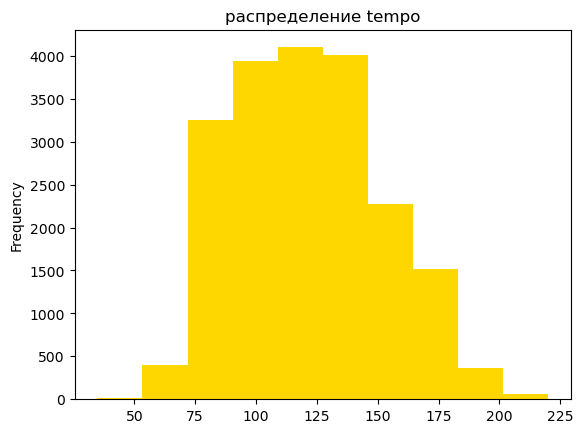

In [10]:
df['tempo'].plot(kind = 'hist', color = '#FFD700', title = 'распределение tempo');

Распределение приближенно к нормальному, поэтому заполнить пропуски медианой по жанрам не самое худшее решение. В любом случае, для улучшения показателей модели на этапе обучения я попробую удалить эти строки и сравнить метрики.

In [11]:
print(df.pivot_table(columns = 'music_genre', values = 'tempo', aggfunc = 'median'))

music_genre  Alternative    Anime    Blues  Classical  Country  Electronic  \
tempo            120.048  128.002  119.118    95.5235   121.97       126.0   

music_genre  Hip-Hop      Jazz     Rap    Rock  
tempo          120.1  105.3485  120.02  120.84  


In [12]:
df.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [13]:
genres = df['music_genre'].unique()
for g in genres:
    df.loc[df['music_genre'] == g, 'tempo'] = df.loc[df['music_genre'] == g,'tempo'].fillna(df.loc[df['music_genre'] == g,'tempo'].median())
    df.loc[df['music_genre'] == g, 'key'] = df.loc[df['music_genre'] == g, 'key'].fillna(df.loc[df['music_genre'] == g, 'key'].mode()[0])
    df.loc[df['music_genre'] == g, 'mode'] = df.loc[df['music_genre'] == g, 'mode'].fillna(df.loc[df['music_genre'] == g, 'mode'].mode()[0])
#в тесте жанров нет, поэтому заполню так:
df_test['tempo'] = df_test['tempo'].fillna(df['tempo'].median())
df_test['key'] = df_test['key'].fillna('D') #заполнил модой
df_test['mode'] = df_test['mode'].fillna('Major') #заполнил модой

Все пропущенные значения я заменил модой или медианой по жанрам.

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


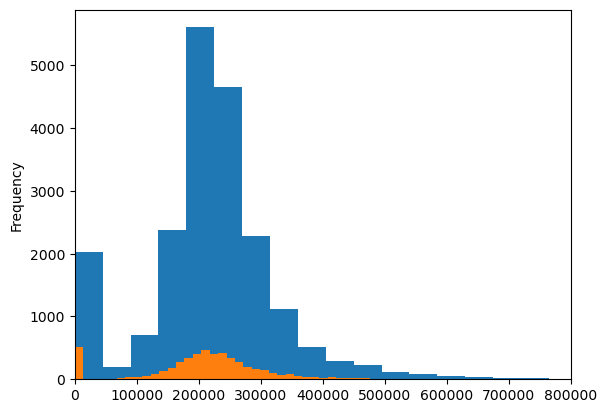

In [14]:
print(df['duration_ms'].plot(kind = 'hist', bins = 100,xlim = (0,80000)));
print(df_test['duration_ms'].plot(kind = 'hist', bins = 100,xlim = (0,800000)));

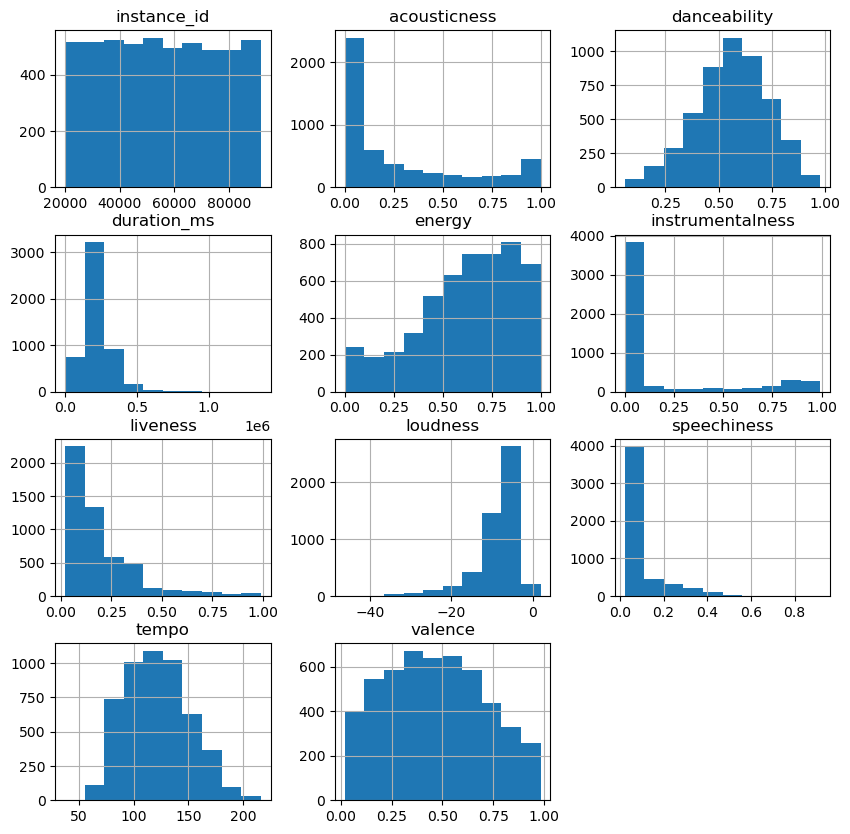

In [15]:
df_test.hist(figsize = (10,10));

# Синтезирование признаков

In [16]:
df['len_name'] = df['track_name'].apply(len)
df_test['len_name'] = df_test['track_name'].apply(len)


столбец с кол-вом символов в названии треков.

2. **ТИПЫ ДАННЫХ**

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               20394 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              20394 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             20394 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
 16  len_name          20394 non-null  int64 

instance_id, duration_ms, obtained_date - не соответствуют типам столбцов.

In [18]:
df[df['duration_ms'] % 1 != 0]

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,len_name


- duration_ms содержит только целочисленные данные, хотя стоит тип float64, нужно изменить.
- instance_id это уникальный id трека, тоже должен быть целочисленный.
- obtained_date тип object, можно было бы привести к типу datetime, но, так как там всего лишь 4 даты выгрузки, я произведу OHE с этим столбцом, попробую дать этот признак модели, но я сделаю это чуть позже.

> Можно было бы на этом этапе произвести удаление признаков, которые не понадобятся нашей модели, но я всё же произведу все преобразования, всю предобработку, а в самом конце буду играть с признаками.

In [19]:
df.obtained_date.value_counts() #4 даты выгрузки

obtained_date
4-Apr    18435
3-Apr     1524
5-Apr      290
1-Apr      145
Name: count, dtype: int64

In [20]:
df = df.astype({'instance_id':'int64', 'duration_ms':'int64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  int64  
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  int64  
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               20394 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              20394 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             20394 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
 16  len_name          20394 non-null  int64 

3. **ВЫБРОСЫ**

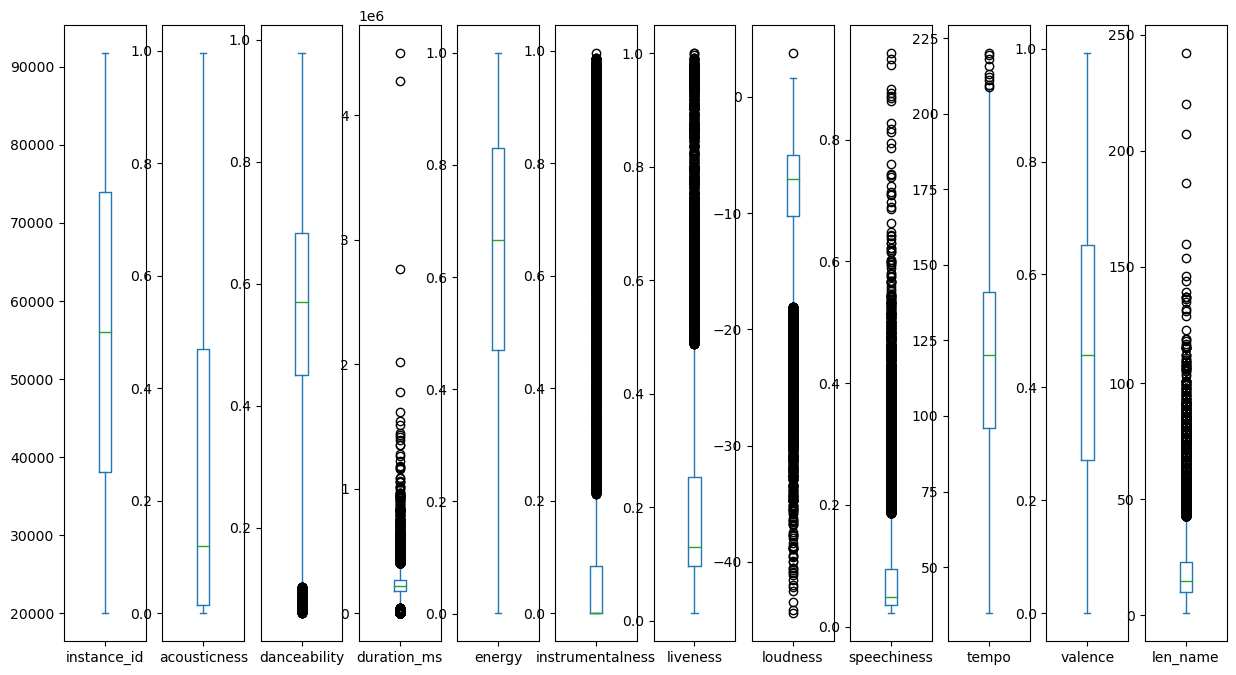

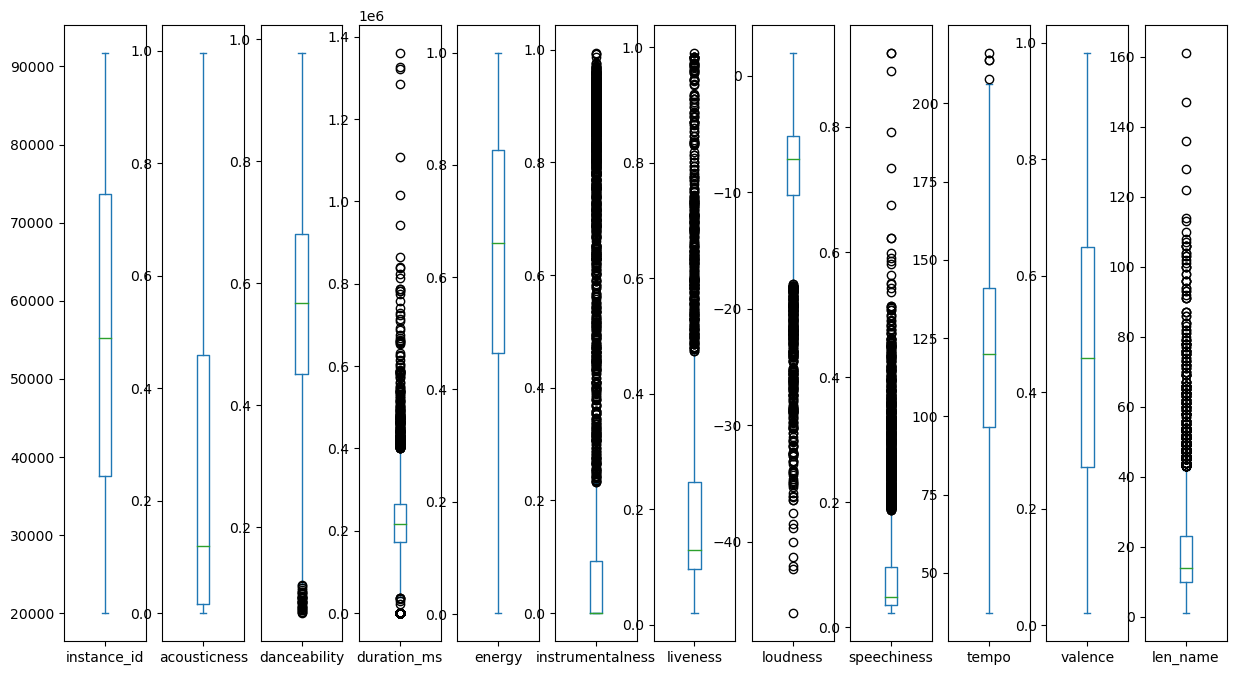

In [21]:
numeric = df.select_dtypes(include=['number'])
df.plot(kind = 'box', subplots = True, figsize = (15,8));
plt.show()
#

#
df_test.plot(kind = 'box', subplots = True, figsize = (15,8));
plt.show()

In [22]:
print(df['duration_ms'].describe())
print(df_test['duration_ms'].describe())

count    2.039400e+04
mean     2.203754e+05
std      1.267283e+05
min     -1.000000e+00
25%      1.775170e+05
50%      2.195330e+05
75%      2.660000e+05
max      4.497994e+06
Name: duration_ms, dtype: float64
count    5.099000e+03
mean     2.173974e+05
std      1.156374e+05
min     -1.000000e+00
25%      1.737335e+05
50%      2.175000e+05
75%      2.642470e+05
max      1.360027e+06
Name: duration_ms, dtype: float64


In [23]:
df.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,len_name
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.904400,0.464588,19.316760
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.119609,0.243387,15.619033
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000,1.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,96.004000,0.272000,10.000000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.028000,0.457000,15.000000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,140.974000,0.653000,23.000000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000,242.000000


In [24]:
df[df['duration_ms'] < 0].count()

instance_id         2009
track_name          2009
acousticness        2009
danceability        2009
duration_ms         2009
energy              2009
instrumentalness    2009
key                 2009
liveness            2009
loudness            2009
mode                2009
speechiness         2009
tempo               2009
obtained_date       2009
valence             2009
music_genre         2009
len_name            2009
dtype: int64

Есть большое кол-во выбросов, в столбце duration_ms есть отрицательные значения, которые смело можно назвать неадекватными.

Эти неадекватные значения я заменю медианой по жанрам. 

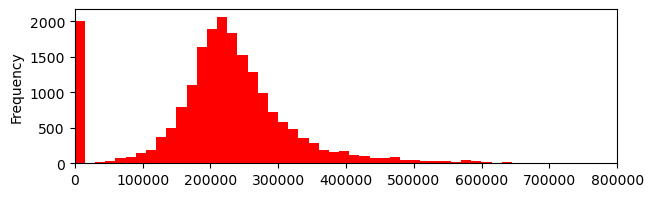

In [25]:
df.duration_ms.plot(kind = 'hist', bins = 300, color = 'red', figsize = (7,2), xlim = (0, 800000));

In [26]:
genres = df['music_genre'].unique()
for g in genres:
    df.loc[((df['duration_ms'] <= 0) & (df['music_genre'] == g)), 'duration_ms'] = df.loc[df['music_genre'] == g, 'duration_ms'].median()

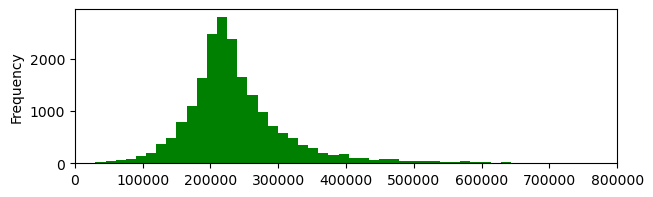

In [27]:
df.duration_ms.plot(kind = 'hist', bins = 300, color = 'green', figsize = (7,2), xlim = (0, 800000));

In [28]:
df.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,len_name
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.422290e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.904400,0.464588,19.316760
std,20695.792545,0.321643,0.171898,1.039813e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.119609,0.243387,15.619033
min,20011.000000,0.000000,0.060000,1.550900e+04,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000,1.000000
25%,38157.250000,0.015200,0.451000,1.960892e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,96.004000,0.272000,10.000000
50%,56030.000000,0.120000,0.570000,2.243845e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.028000,0.457000,15.000000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,140.974000,0.653000,23.000000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000,242.000000


instance_id            Axes(0.125,0.11;0.0545775x0.77)
acousticness        Axes(0.190493,0.11;0.0545775x0.77)
danceability        Axes(0.255986,0.11;0.0545775x0.77)
duration_ms         Axes(0.321479,0.11;0.0545775x0.77)
energy              Axes(0.386972,0.11;0.0545775x0.77)
instrumentalness    Axes(0.452465,0.11;0.0545775x0.77)
liveness            Axes(0.517958,0.11;0.0545775x0.77)
loudness            Axes(0.583451,0.11;0.0545775x0.77)
speechiness         Axes(0.648944,0.11;0.0545775x0.77)
tempo               Axes(0.714437,0.11;0.0545775x0.77)
valence              Axes(0.77993,0.11;0.0545775x0.77)
len_name            Axes(0.845423,0.11;0.0545775x0.77)
dtype: object

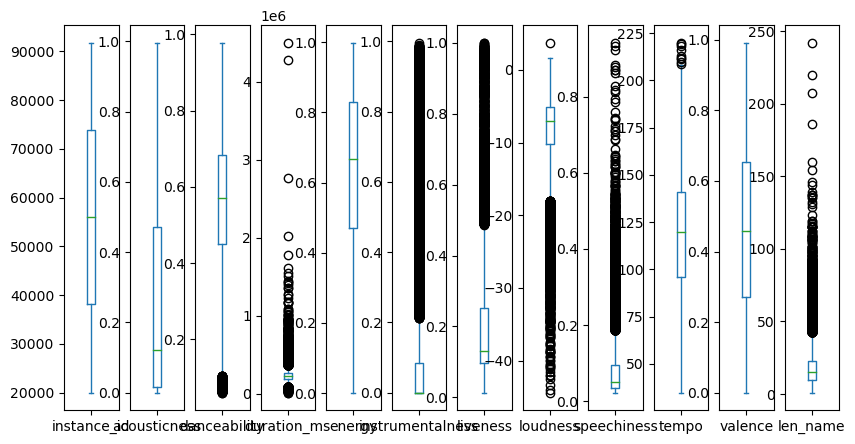

In [29]:
#numeric = ['danceability', 'tempo']
#for num in numeric:
#    q1 = df[num].quantile(0.25)
#    q3 = df[num].quantile(0.75)
#    iqr = df[num].quantile(0.75) - df[num].quantile(0.25)
##    df = df[(df[num] > (q1 - 1.5 * iqr)) & (df[num] < (q3 + 1.5 * iqr))]
#    
#df = df[(df['duration_ms'] < 2000000) & (df['duration_ms'] > 0)]
plot = df.columns.to_list()
#plot.remove('len_name')
df[plot].plot(kind = 'box', subplots = True, figsize = (10,5))

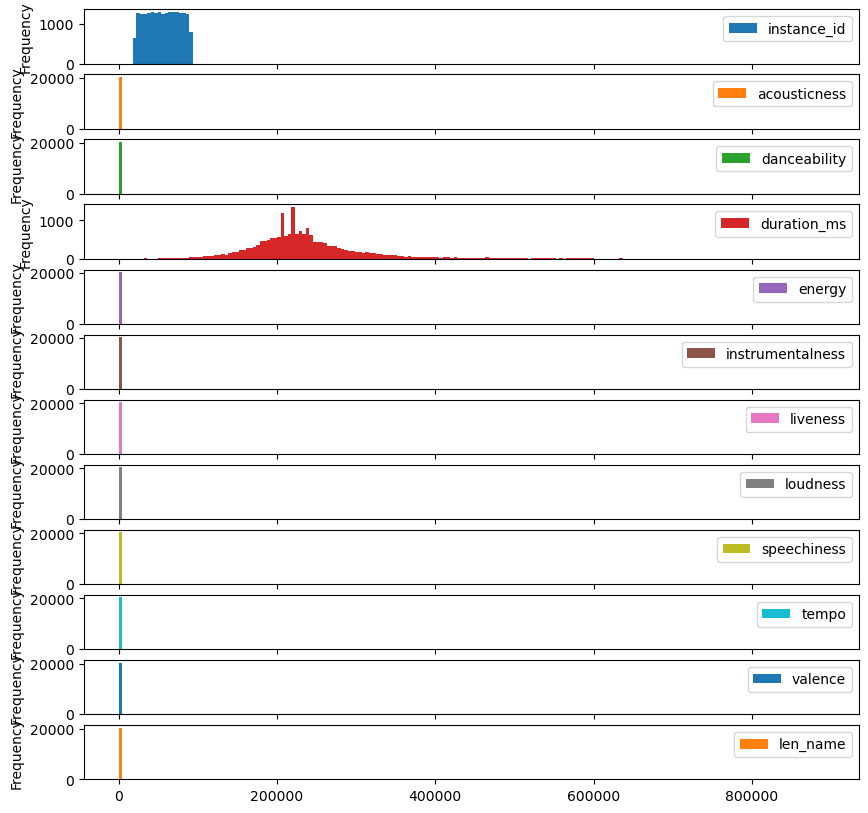

In [30]:
#df.loc[df['duration_ms'] > 700000, 'duration_ms'] = df['duration_ms'].median()
col_high_plus = ['duration_ms']
for col in col_high_plus:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    high = q3 + 9*iqr
    df.loc[df[col] > high, col] = df[col].median()

col_high_plus = ['valence']
for col in col_high_plus:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    high = q3 + 2*iqr
    df.loc[df[col] > high, col] = df[col].median()

df.loc[df['len_name'] > 160, 'len_name'] = df['len_name'].median()



df[plot].plot(kind = 'hist', subplots = True, figsize = (10,10), bins = 200);

Кое-где обрезал выбросы.

In [31]:
print(df.shape[0])


20394


3. **МУЛЬТИКОЛЛИНЕАРНОСТЬ**

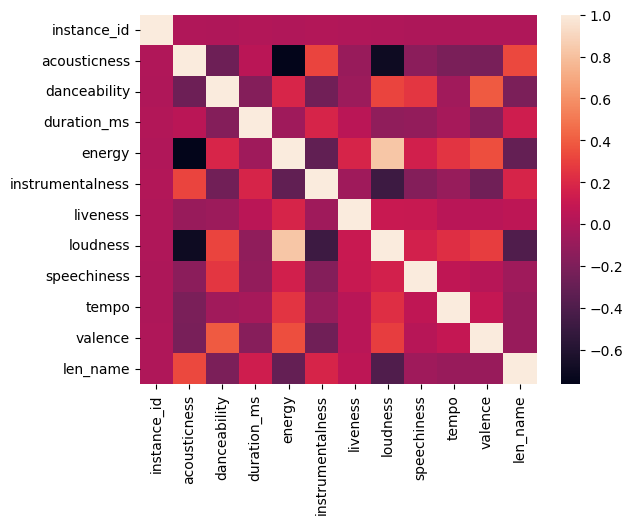

In [32]:
numeric = df.select_dtypes(include=['number'])
sns.heatmap(numeric.corr());

In [33]:
numeric = df.select_dtypes(include=['number'])
numeric.corr() > 0.5 

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,len_name
instance_id,True,False,False,False,False,False,False,False,False,False,False,False
acousticness,False,True,False,False,False,False,False,False,False,False,False,False
danceability,False,False,True,False,False,False,False,False,False,False,False,False
duration_ms,False,False,False,True,False,False,False,False,False,False,False,False
energy,False,False,False,False,True,False,False,True,False,False,False,False
instrumentalness,False,False,False,False,False,True,False,False,False,False,False,False
liveness,False,False,False,False,False,False,True,False,False,False,False,False
loudness,False,False,False,False,True,False,False,True,False,False,False,False
speechiness,False,False,False,False,False,False,False,False,True,False,False,False
tempo,False,False,False,False,False,False,False,False,False,True,False,False


In [34]:
df[['energy', 'loudness']].corr()

,energy,loudness
energy,1.000000,0.821801
loudness,0.821801,1.000000


Найдены два признака, которые имеют высокий коэфф. корреляции - 0.82.

Корреляция может негативно повлиять на обучение модели, поэтому один из признаков нужно удалить.

(удалил, метрика упала)

In [35]:
numeric.corr() < -0.5 

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,len_name
instance_id,False,False,False,False,False,False,False,False,False,False,False,False
acousticness,False,False,False,False,True,False,False,True,False,False,False,False
danceability,False,False,False,False,False,False,False,False,False,False,False,False
duration_ms,False,False,False,False,False,False,False,False,False,False,False,False
energy,False,True,False,False,False,False,False,False,False,False,False,False
instrumentalness,False,False,False,False,False,False,False,False,False,False,False,False
liveness,False,False,False,False,False,False,False,False,False,False,False,False
loudness,False,True,False,False,False,False,False,False,False,False,False,False
speechiness,False,False,False,False,False,False,False,False,False,False,False,False
tempo,False,False,False,False,False,False,False,False,False,False,False,False


In [36]:
df[['energy', 'acousticness', 'loudness']].corr()

,energy,acousticness,loudness
energy,1.000000,-0.764949,0.821801
acousticness,-0.764949,1.000000,-0.699716
loudness,0.821801,-0.699716,1.000000


Между несколькими признаками есть высокая отрицательная корреляция:
- energy and acousticness
- loudness and acousticness

acousticness также будет удален, их корреляция может помешать обучению модели.

(удалил, метрика упала)

interval columns not set, guessing: ['instance_id', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'len_name']


/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_17945/2723994779.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


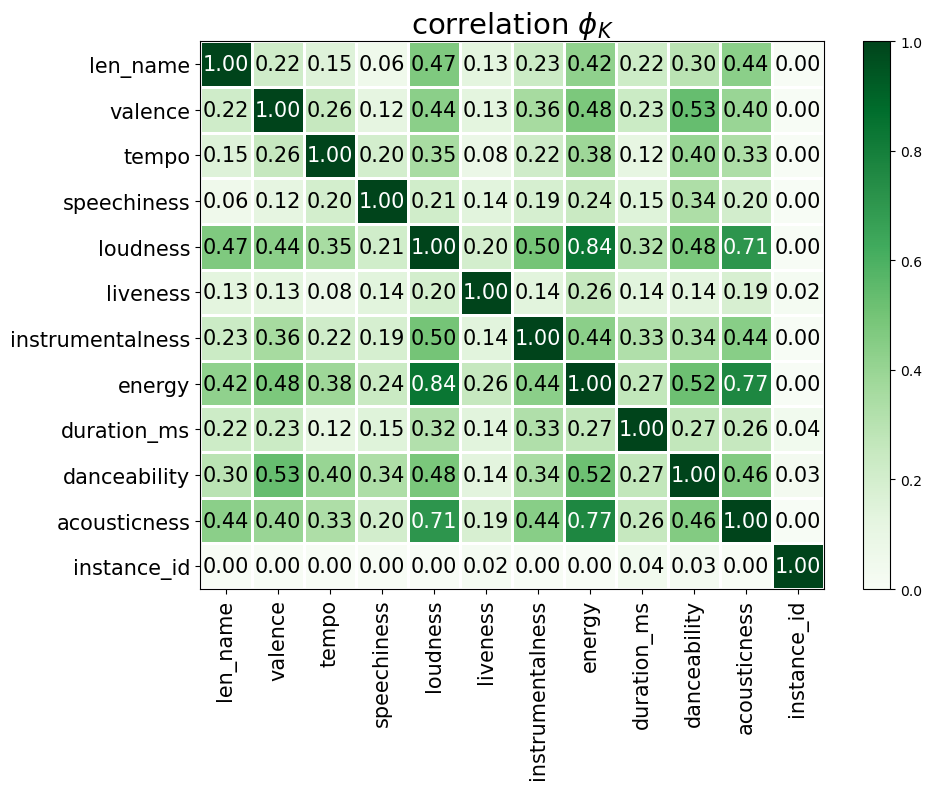

In [37]:
numeric = df.select_dtypes(include=['number'])
phik_overview = numeric.phik_matrix()
#phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

In [38]:
#rep = report.correlation_report(numeric, significance_threshold=3, correlation_threshold=0.5)
#rep

Максимальный коэфф. корреляции Phik - 0.5. На данный момент пытаться исправлять эту проблему не буду. Возможно только в ходе машинного обучения.

4. **ДУБЛИКАТЫ**

In [39]:
df.duplicated().sum()

0

In [40]:
df['instance_id'].duplicated().sum()

0

Явных дубликатов нет. Названия треков могут повторяться.

In [41]:
df[['track_name', 'duration_ms', 'key']].duplicated().sum()

522

In [42]:
df[['track_name', 'duration_ms', 'key']] = df[['track_name', 'duration_ms', 'key']].drop_duplicates()
df = df.dropna()
df.shape[0]

19872

Удалил неявные дубликаты. Их было 503 строки.

5. Разведочный анализ.

In [43]:
#PP = df.copy()
#ProfileReport(PP)

В столбце instrumentalness 30% данных - нули.

В остальном данные выглядят адекватно, за исключением большого кол-ва пропусков.

**РАСПРЕДЕЛЕНИЯ**

In [44]:
df_test.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,len_name
count,5099.000000,5099.000000,5099.000000,5.099000e+03,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000
mean,55643.871347,0.276324,0.561888,2.173974e+05,0.622030,0.165198,0.197924,-8.630186,0.092718,121.217549,0.465593,19.156109
std,20762.384803,0.322657,0.170502,1.156374e+05,0.251829,0.311940,0.166241,5.619766,0.100130,29.519854,0.244217,15.441075
min,20012.000000,0.000002,0.059600,-1.000000e+00,0.001540,0.000000,0.020400,-46.122000,0.022600,37.114000,0.020500,1.000000
25%,37571.000000,0.016600,0.451000,1.737335e+05,0.465000,0.000000,0.096950,-10.231000,0.035700,96.732500,0.272000,10.000000
50%,55246.000000,0.120000,0.568000,2.175000e+05,0.660000,0.000157,0.129000,-7.135000,0.048700,120.028000,0.458000,14.000000
75%,73702.000000,0.460000,0.681000,2.642470e+05,0.826000,0.092750,0.248000,-5.127000,0.096550,141.002500,0.650000,23.000000
max,91709.000000,0.996000,0.977000,1.360027e+06,0.999000,0.994000,0.990000,1.949000,0.918000,216.029000,0.982000,161.000000


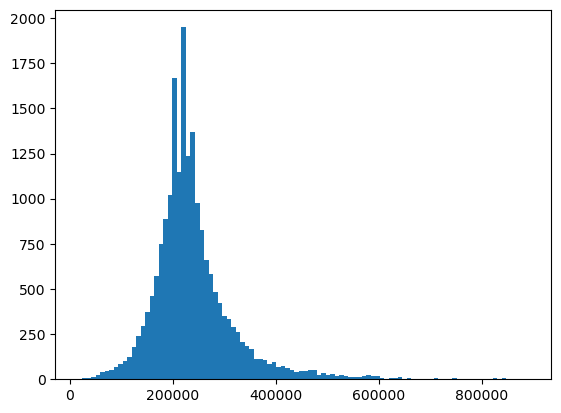

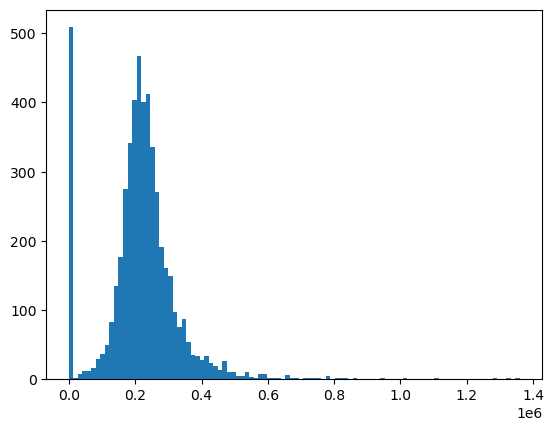

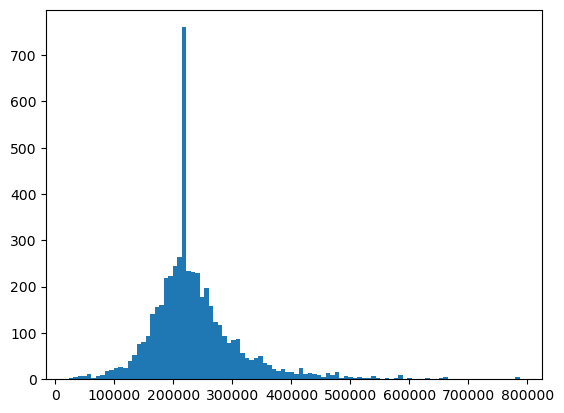

In [45]:
plt.hist(df['duration_ms'], bins=100); plt.show()
plt.hist(df_test['duration_ms'], bins=100); plt.show()
df_test.loc[(df_test['duration_ms'] < 10, 'duration_ms')] = df_test['duration_ms'].median()
df_test.loc[(df_test['duration_ms'] > 800000, 'duration_ms')] = df_test['duration_ms'].median()

plt.hist(df_test['duration_ms'], bins=100); plt.show()

In [46]:
print(df['key'].value_counts())
print(df_test['key'].value_counts())

key
G     2581
C#    2295
D     2173
C     2097
A     1959
F     1620
E     1488
B     1472
G#    1231
A#    1188
F#    1179
D#     589
Name: count, dtype: int64
key
D     715
C     530
G     527
C#    495
A     465
F     464
B     397
A#    354
E     349
F#    333
G#    314
D#    156
Name: count, dtype: int64


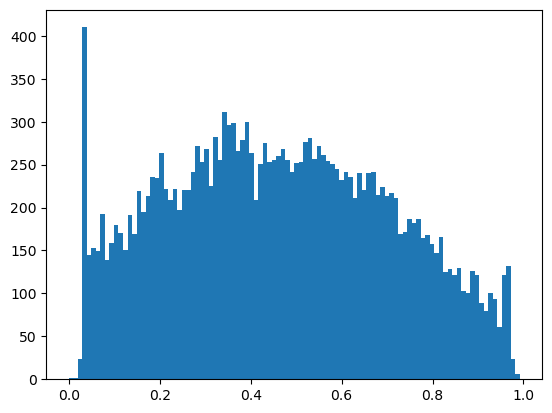

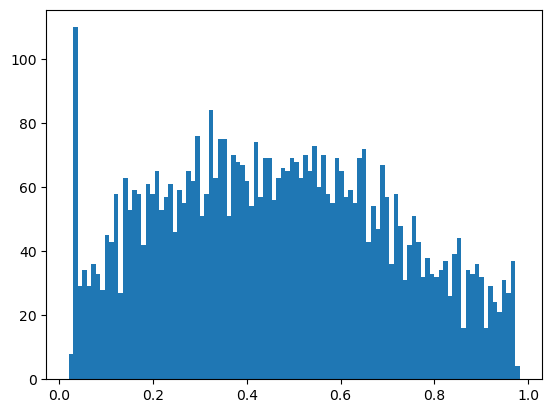

In [47]:
#df.loc[df['valence']< 0.05, 'valence'] = df['valence'].median()
#df_test.loc[df_test['valence']< 0.05, 'valence'] = df_test['valence'].median()
plt.hist(df['valence'], bins=100); plt.show()
plt.hist(df_test['valence'], bins=100); plt.show()

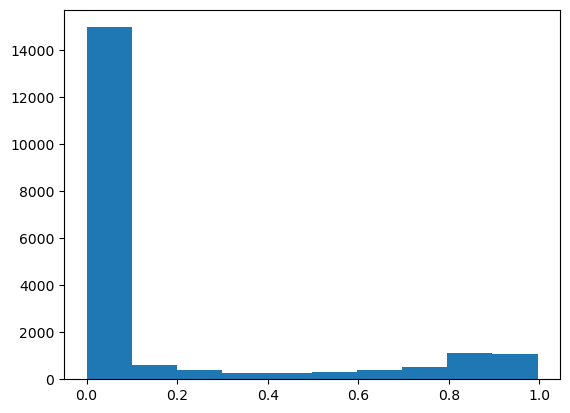

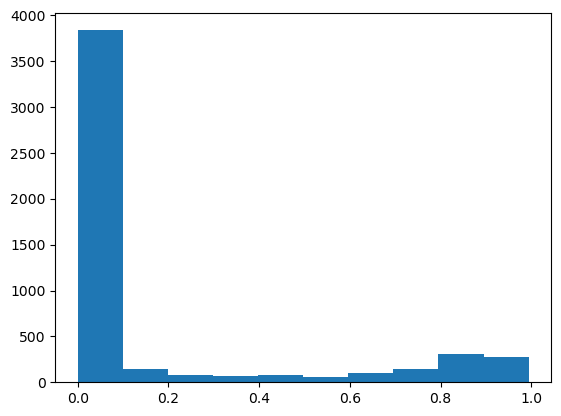

In [48]:
plt.hist(df['instrumentalness']); plt.show()
plt.hist(df_test['instrumentalness']); plt.show()

# Обработка kaggle_music_genre_test

In [49]:
df_test.isna().sum()

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
len_name            0
dtype: int64

пропуски в tempo, в датафрейме train я заполнял медианой по жанрам. Тут жанров нет, поэтому tempo я заполню медианой.

In [50]:
df_test.info()
df_sint = df.copy()
df_test_sint = df_test.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               5099 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              5099 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             5099 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
 15  len_name          5099 non-null   int64  
dtypes: float64(10), int64(2), object(4)
memory

# Машинное обучение

1. Подготовка данных.

**Удаление признаков**

In [51]:
df = df.drop(['instance_id', 'track_name', 'obtained_date'], axis = 1 )
df_rfc = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19872 entries, 0 to 20393
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      19872 non-null  float64
 1   danceability      19872 non-null  float64
 2   duration_ms       19872 non-null  float64
 3   energy            19872 non-null  float64
 4   instrumentalness  19872 non-null  float64
 5   key               19872 non-null  object 
 6   liveness          19872 non-null  float64
 7   loudness          19872 non-null  float64
 8   mode              19872 non-null  object 
 9   speechiness       19872 non-null  float64
 10  tempo             19872 non-null  float64
 11  valence           19872 non-null  float64
 12  music_genre       19872 non-null  object 
 13  len_name          19872 non-null  int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 2.3+ MB


**OHE**

In [52]:
ohe_features_ridge = df_rfc.select_dtypes(include='object').columns.to_list()
ohe_features_ridge.remove('music_genre')
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder_ohe.fit(df_rfc[ohe_features_ridge])
df_rfc[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(df_rfc[ohe_features_ridge])
df_rfc = df_rfc.drop(ohe_features_ridge, axis=1)

df_rfc

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor
0,0.48000,0.670,182653.0,0.351,0.017600,0.1150,-16.842,0.0463,101.384,0.450,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.24300,0.452,187133.0,0.670,0.000051,0.1080,-8.392,0.0352,113.071,0.539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.22800,0.454,173448.0,0.804,0.000000,0.1810,-5.225,0.3710,80.980,0.344,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.05580,0.847,255987.0,0.873,0.000003,0.3250,-4.805,0.0804,116.007,0.966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.22700,0.742,195333.0,0.575,0.000002,0.1760,-5.550,0.0487,76.494,0.583,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20389,0.71900,0.725,235467.0,0.483,0.000000,0.0797,-13.314,0.0438,87.413,0.942,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
20390,0.19000,0.482,198933.0,0.362,0.005620,0.0913,-10.358,0.0299,76.879,0.174,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
20391,0.00061,0.663,220947.0,0.886,0.000025,0.2840,-4.149,0.0358,146.803,0.942,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20392,0.00310,0.914,162214.0,0.515,0.000000,0.1050,-9.934,0.3560,150.016,0.215,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Масштабирование признаков**

In [53]:
scaler = StandardScaler()
numeric = df_rfc.select_dtypes(include=['number'])
scaler.fit(df_rfc[numeric.columns])
df_rfc[numeric.columns] = scaler.transform(df_rfc[numeric.columns])

**Деление на выборки**

In [54]:
df_x, df_y = train_test_split(df_rfc, test_size = 0.25, random_state = 42, stratify = df_rfc['music_genre'])
print(df_x.shape[0], df_y.shape[0])

14904 4968


In [55]:
df_x_target = df_x['music_genre']
df_x_features = df_x.drop('music_genre', axis = 1)
df_y_target = df_y['music_genre']
df_y_features = df_y.drop('music_genre', axis = 1)

In [56]:
df_y_features.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'len_name', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D',
       'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'mode_Minor'],
      dtype='object')

In [57]:
df_y_target.value_counts()

music_genre
Blues          704
Electronic     637
Alternative    624
Rap            580
Country        523
Rock           511
Anime          474
Classical      342
Jazz           307
Hip-Hop        266
Name: count, dtype: int64

**Обучение моделей**

In [58]:
best_f1 = 0
for depth in [8]:
    for n in [50]:
        model_rfc = RandomForestClassifier()
        model_rfc.fit(df_x_features, df_x_target)
        pred = model_rfc.predict(df_y_features)
        f1 = f1_score(df_y_target, pred, average = 'micro')
        if f1 > best_f1:
            best_depth = depth
            best_n = n
            best_f1 = f1
print(best_f1, best_n, best_depth)

0.48168276972624796 50 8


# Исследование модели

In [59]:
df = df_sint.copy()
df_test = df_test_sint.copy()
df_test_i = df_test.copy()
df_test = df_test.drop(['instance_id', 'track_name'], axis = 1)
df = df.drop(['instance_id','track_name'], axis = 1)

## CatBoost

In [60]:
data, val = train_test_split(df, 
                             test_size = 0.25, 
                             random_state = 42,
                             stratify = df['music_genre'])
data_target = data['music_genre']
data_features = data.drop('music_genre', axis = 1)

val_target = val['music_genre']
val_features = val.drop('music_genre', axis = 1)

numeric = data_features.select_dtypes(include=['number']).columns.to_list()
objects = data_features.select_dtypes(include=['object', 'category']).columns.to_list()

model_cb = CatBoostClassifier(cat_features = objects,
                              eval_metric = 'TotalF1',
                              verbose = 100,
                              random_seed = 42,
                             learning_rate = 0.07)

model_cb.fit(data_features, 
             data_target,
             eval_set = (val_features, val_target))

0:	learn: 0.3119920	test: 0.3141289	best: 0.3141289 (0)	total: 106ms	remaining: 1m 46s
100:	learn: 0.4919532	test: 0.4643550	best: 0.4643550 (100)	total: 7.11s	remaining: 1m 3s
200:	learn: 0.5493036	test: 0.5028783	best: 0.5028783 (200)	total: 13s	remaining: 51.8s
300:	learn: 0.5904377	test: 0.5146963	best: 0.5155870 (285)	total: 18.4s	remaining: 42.8s
400:	learn: 0.6174655	test: 0.5200481	best: 0.5218122 (396)	total: 23.8s	remaining: 35.6s
500:	learn: 0.6467725	test: 0.5203724	best: 0.5228850 (407)	total: 29.1s	remaining: 29s
600:	learn: 0.6724497	test: 0.5269277	best: 0.5283296 (583)	total: 34.4s	remaining: 22.8s
700:	learn: 0.6951568	test: 0.5269215	best: 0.5289662 (668)	total: 39.8s	remaining: 17s
800:	learn: 0.7164021	test: 0.5298175	best: 0.5304311 (783)	total: 45.1s	remaining: 11.2s
900:	learn: 0.7361874	test: 0.5296785	best: 0.5318030 (853)	total: 50.5s	remaining: 5.55s
999:	learn: 0.7610317	test: 0.5298391	best: 0.5318030 (853)	total: 55.8s	remaining: 0us

bestTest = 0.5318030

In [61]:
model_cb = CatBoostClassifier(cat_features = objects,
                              eval_metric = 'TotalF1',
                              verbose = 100,
                              random_seed = 42,
                              iterations = model_cb.best_iteration_ + 1,
                             learning_rate = 0.04)
model_cb.fit(pd.concat([data_features,val_features]), 
             pd.concat([data_target, val_target]))

0:	learn: 0.3176615	total: 65.5ms	remaining: 55.8s
100:	learn: 0.4524313	total: 6.65s	remaining: 49.6s
200:	learn: 0.4984879	total: 13.8s	remaining: 44.9s
300:	learn: 0.5292968	total: 22s	remaining: 40.5s
400:	learn: 0.5529345	total: 29.8s	remaining: 33.7s
500:	learn: 0.5725868	total: 38.1s	remaining: 26.9s
600:	learn: 0.5866989	total: 45.7s	remaining: 19.2s
700:	learn: 0.5998071	total: 53.2s	remaining: 11.6s
800:	learn: 0.6112256	total: 1m	remaining: 4.02s
853:	learn: 0.6189194	total: 1m 4s	remaining: 0us


In [63]:
#df_test = df_test.drop(['instance_id', 'track_name', 'obtained_date'], axis = 1)
#pred = pd.DataFrame()
#pred = model_cb.predict(df_test)
#pred = pd.DataFrame(pred)
#pred['instance_id'] = df_test_i['instance_id']
#pred.set_index('instance_id')
#predictions = pd.DataFrame()
#predictions['instance_id'] = pred['instance_id']
#predictions['music_genre'] = pred[0]
#predictions.to_csv('/Users/artemmm/Desktop/answers.csv', index = False)

catboost показывает неплохие результаты.

## XGBoost

In [64]:
#кодирование
#train
print(df.music_genre.value_counts())
k = 0
for g in df.music_genre.unique():
    df.loc[df['music_genre'] == g, 'music_genre'] = k
    k += 1
print(df.music_genre.value_counts())

ohe_features = df.select_dtypes(include='object').columns.to_list()
ohe_features.remove('music_genre')
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder_ohe.fit(df[ohe_features])
df[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(df[ohe_features])
df = df.drop(ohe_features, axis=1)
#test
ohe_features = df_test.select_dtypes(include='object').columns.to_list()
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder_ohe.fit(df_test[ohe_features])
df_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(df_test[ohe_features])
df_test = df_test.drop(ohe_features, axis=1)

df

music_genre
Blues          2818
Electronic     2548
Alternative    2495
Rap            2319
Country        2090
Rock           2046
Anime          1896
Classical      1370
Jazz           1227
Hip-Hop        1063
Name: count, dtype: int64
music_genre
4    2818
6    2548
2    2495
8    2319
0    2090
1    2046
7    1896
9    1370
5    1227
3    1063
Name: count, dtype: int64


,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor,obtained_date_3-Apr,obtained_date_4-Apr,obtained_date_5-Apr
0,0.48000,0.670,182653.0,0.351,0.017600,0.1150,-16.842,0.0463,101.384,0.450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.24300,0.452,187133.0,0.670,0.000051,0.1080,-8.392,0.0352,113.071,0.539,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.22800,0.454,173448.0,0.804,0.000000,0.1810,-5.225,0.3710,80.980,0.344,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.05580,0.847,255987.0,0.873,0.000003,0.3250,-4.805,0.0804,116.007,0.966,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.22700,0.742,195333.0,0.575,0.000002,0.1760,-5.550,0.0487,76.494,0.583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20389,0.71900,0.725,235467.0,0.483,0.000000,0.0797,-13.314,0.0438,87.413,0.942,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
20390,0.19000,0.482,198933.0,0.362,0.005620,0.0913,-10.358,0.0299,76.879,0.174,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
20391,0.00061,0.663,220947.0,0.886,0.000025,0.2840,-4.149,0.0358,146.803,0.942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20392,0.00310,0.914,162214.0,0.515,0.000000,0.1050,-9.934,0.3560,150.016,0.215,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [65]:
model_xgb = xgb.XGBClassifier(
                            learning_rate=0.01,
                            max_depth = 6,
                            n_estimators = 1000)
df['music_genre'] = df['music_genre'].astype('category')
data, val = train_test_split(df, 
                             test_size = 0.25, 
                             random_state = 42,
                             stratify = df['music_genre'])
data_target = data['music_genre']
data_features = data.drop('music_genre', axis = 1)

val_target = val['music_genre']
val_features = val.drop('music_genre', axis = 1)

model_xgb.fit(data_features, 
             data_target)
val_pred = model_xgb.predict(val_features)
print(f1_score(val_target, val_pred, average = 'micro'))

0.5372383252818036


In [66]:
model_xgb.fit(pd.concat([data_features,val_features]), 
             pd.concat([data_target, val_target]))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [67]:
pred = pd.DataFrame()
pred = model_xgb.predict(df_test)
pred = pd.DataFrame(pred)
pred['instance_id'] = df_test_i['instance_id']
pred.set_index('instance_id')
predictions = pd.DataFrame()
predictions['instance_id'] = pred['instance_id']
predictions['music_genre'] = pred[0]
predictions.loc[predictions['music_genre'] == 4, 'music_genre'] = 'Blues'
predictions.loc[predictions['music_genre'] == 6, 'music_genre'] = 'Electronic'
predictions.loc[predictions['music_genre'] == 2, 'music_genre'] = 'Alternative'
predictions.loc[predictions['music_genre'] == 8, 'music_genre'] = 'Rap'
predictions.loc[predictions['music_genre'] == 0, 'music_genre'] = 'Country'
predictions.loc[predictions['music_genre'] == 1, 'music_genre'] = 'Rock'
predictions.loc[predictions['music_genre'] == 7, 'music_genre'] = 'Anime'
predictions.loc[predictions['music_genre'] == 9, 'music_genre'] = 'Classical'
predictions.loc[predictions['music_genre'] == 5, 'music_genre'] = 'Jazz'
predictions.loc[predictions['music_genre'] == 3, 'music_genre'] = 'Hip-Hop'

predictions.to_csv('/Users/artemmm/Desktop/answers.csv', index = False)

результаты оказались хуже, чем у catboost

# обучение по названиям

In [68]:
df = df_sint.copy()
df_test = df_test_sint.copy()
df_test_i = df_test.copy()
df_test = df_test.drop(['instance_id'], axis = 1)
df = df.drop(['instance_id'], axis = 1)

In [69]:
for i in range(0,10):
    df[i] = 0
    df_test[i] = 0
df['track_name'] = df['track_name'].str.lower()
df_test['track_name'] = df_test['track_name'].str.lower()
for index, row in df.iterrows():
    if 'minor' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 2] = -1
    if 'act' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 2] = -1
    if 'iii' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 2] = -1
    if 'symphony' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 5] = -1
    if 'piano' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 4] = -1
    if 'major' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 8] = -1
    if 'suite' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 9] = -1
    if 'sonata' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 7] = -1
    if 'remix' in row['track_name']:
        df.loc[index, 5] = 1
        df.loc[index, 4] = -1
    if 'string' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 2] = -1
    if 'final' in row['track_name']:
        df.loc[index, 1] = 1
        df.loc[index, 5] = -1
    if 'flat' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 2] = -1
    if 'fantasy' in row['track_name']:
        df.loc[index, 1] = 1
        df.loc[index, 5] = -1
    if 'cello' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 1] = -1
    if 'remastered' in row['track_name']:
        df.loc[index, 9] = 1
        df.loc[index, 1] = -1
    if 'lil' in row['track_name']:
        df.loc[index, 6] = 1
        df.loc[index, 2] = -1
    if 'variations' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 5] = -1
    if 'blues' in row['track_name']:
        df.loc[index, 2] = 1
        df.loc[index, 3] = -1
    if 'trio' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 2] = -1
    if 'live' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 6] = -1
    if 'mix' in row['track_name']:
        df.loc[index, 5] = 1
        df.loc[index, 0] = -1
    if 'theme' in row['track_name']:
        df.loc[index, 1] = 1
        df.loc[index, 4] = -1
    ###
    if 'woman' in row['track_name']:
        df.loc[index, 2] = 1
        df.loc[index, 4] = -1
    if 'con' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 5] = -1
    if 'stage' in row['track_name']:
        df.loc[index, 1] = 1
        df.loc[index, 2] = -1
    if 'original' in row['track_name']:
        df.loc[index, 5] = 1
        df.loc[index, 4] = -1
    if 'variation' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 5] = -1
    if 'feat' in row['track_name']:
        df.loc[index, 6] = 1
        df.loc[index, 3] = -1
    if 'got' in row['track_name']:
        df.loc[index, 2] = 1
        df.loc[index, 1] = -1
    if 'passion' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 0] = -1
    if 'single' in row['track_name']:
        df.loc[index, 2] = 1
        df.loc[index, 5] = -1    
    if 'instrumental' in row['track_name']:
        df.loc[index, 7] = 1
        df.loc[index, 2] = -1   
    if 'les' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 8] = -1 
    if 'book' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 2] = -1
    if 'die' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 1] = -1
    if 'orchestra' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 2] = -1
    if 'road' in row['track_name']:
        df.loc[index, 4] = 1
        df.loc[index, 5] = -1    
    if 'dream' in row['track_name']:
        df.loc[index, 7] = 1
        df.loc[index, 5] = -1  
    if 'remaster' in row['track_name']:
        df.loc[index, 2] = 1
        df.loc[index, 1] = -1  
    if 'acoustic' in row['track_name']:
        df.loc[index, 4] = 1
        df.loc[index, 5] = -1  
    if 'country' in row['track_name']:
        df.loc[index, 4] = 1
        df.loc[index, 0] = -1  
    if 'moderato' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 7] = -1     
    if 'non' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 7] = -1  
    if 'love' in row['track_name']:
        df.loc[index, 9] = 1
        df.loc[index, 3] = -1  
    if 'money' in row['track_name']:
        df.loc[index, 6] = 1
        df.loc[index, 2] = -1  
    if 'little' in row['track_name']:
        df.loc[index, 2] = 1
        df.loc[index, 1] = -1  
    if 'flute' in row['track_name']:
        df.loc[index, 3] = 1
        df.loc[index, 2] = -1  
    if 'edit' in row['track_name']:
        df.loc[index, 5] = 1
        df.loc[index, 6] = -1  
    if "ain't" in row['track_name']:
        df.loc[index, 4] = 1
        df.loc[index, 5] = -1      
    if 'old' in row['track_name']:
        df.loc[index, 4] = 1
        df.loc[index, 5] = -1  
        
for index, row in df_test.iterrows():
    if 'minor' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 2] = -1
    if 'act' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 2] = -1
    if 'iii' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 2] = -1
    if 'symphony' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 5] = -1
    if 'piano' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 4] = -1
    if 'major' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 8] = -1
    if 'suite' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 9] = -1
    if 'sonata' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 7] = -1
    if 'remix' in row['track_name']:
        df_test.loc[index, 5] = 1
        df_test.loc[index, 4] = -1
    if 'string' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 2] = -1
    if 'final' in row['track_name']:
        df_test.loc[index, 1] = 1
        df_test.loc[index, 5] = -1
    if 'flat' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 2] = -1
    if 'fantasy' in row['track_name']:
        df_test.loc[index, 1] = 1
        df_test.loc[index, 5] = -1
    if 'cello' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 1] = -1
    if 'remastered' in row['track_name']:
        df_test.loc[index, 9] = 1
        df_test.loc[index, 1] = -1
    if 'lil' in row['track_name']:
        df_test.loc[index, 6] = 1
        df_test.loc[index, 2] = -1
    if 'variations' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 5] = -1
    if 'blues' in row['track_name']:
        df_test.loc[index, 2] = 1
        df_test.loc[index, 3] = -1
    if 'trio' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 2] = -1
    if 'live' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 6] = -1
    if 'mix' in row['track_name']:
        df_test.loc[index, 5] = 1
        df_test.loc[index, 0] = -1
    if 'theme' in row['track_name']:
        df_test.loc[index, 1] = 1
        df_test.loc[index, 4] = -1
    if 'woman' in row['track_name']:
        df_test.loc[index, 2] = 1
        df_test.loc[index, 4] = -1
    if 'con' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 5] = -1
    if 'stage' in row['track_name']:
        df_test.loc[index, 1] = 1
        df_test.loc[index, 2] = -1
    if 'original' in row['track_name']:
        df_test.loc[index, 5] = 1
        df_test.loc[index, 4] = -1
    if 'variation' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 5] = -1
    if 'feat' in row['track_name']:
        df_test.loc[index, 6] = 1
        df_test.loc[index, 3] = -1
    if 'got' in row['track_name']:
        df_test.loc[index, 2] = 1
        df_test.loc[index, 1] = -1
    if 'passion' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 0] = -1
    if 'single' in row['track_name']:
        df_test.loc[index, 2] = 1
        df_test.loc[index, 5] = -1    
    if 'instrumental' in row['track_name']:
        df_test.loc[index, 7] = 1
        df_test.loc[index, 2] = -1   
    if 'les' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 8] = -1 
    if 'book' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 2] = -1
    if 'die' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 1] = -1
    if 'orchestra' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 2] = -1
    if 'road' in row['track_name']:
        df_test.loc[index, 4] = 1
        df_test.loc[index, 5] = -1    
    if 'dream' in row['track_name']:
        df_test.loc[index, 7] = 1
        df_test.loc[index, 5] = -1  
    if 'remaster' in row['track_name']:
        df_test.loc[index, 2] = 1
        df_test.loc[index, 1] = -1  
    if 'acoustic' in row['track_name']:
        df_test.loc[index, 4] = 1
        df_test.loc[index, 5] = -1  
    if 'country' in row['track_name']:
        df_test.loc[index, 4] = 1
        df_test.loc[index, 0] = -1  
    if 'moderato' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 7] = -1     
    if 'non' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 7] = -1  
    if 'love' in row['track_name']:
        df_test.loc[index, 9] = 1
        df_test.loc[index, 3] = -1  
    if 'money' in row['track_name']:
        df_test.loc[index, 6] = 1
        df_test.loc[index, 2] = -1  
    if 'little' in row['track_name']:
        df_test.loc[index, 2] = 1
        df_test.loc[index, 1] = -1  
    if 'flute' in row['track_name']:
        df_test.loc[index, 3] = 1
        df_test.loc[index, 2] = -1  
    if 'edit' in row['track_name']:
        df_test.loc[index, 5] = 1
        df_test.loc[index, 6] = -1  
    if "ain't" in row['track_name']:
        df_test.loc[index, 4] = 1
        df_test.loc[index, 5] = -1      
    if 'old' in row['track_name']:
        df_test.loc[index, 4] = 1
        df_test.loc[index, 5] = -1  
def contains_chinese(check_str):
    for ch in check_str:
        if '\u4e00' <= ch <= '\u9fa5': return 1 # китайский
        if '\uac00' <= ch <= '\ud7a3': return 1 # корейский 
        if '\u0800' <= ch <= '\u4e00': return 1# японский
    return 0
df['contains_iero'] = [contains_chinese(x) for x in df.track_name]
df_test['contains_iero'] = [contains_chinese(x) for x in df_test.track_name]
        

Весь код что выше основан на данных NaiveBayesClassifier, который был сделан в другой тетрадке. Полностью воспользоваться моделью не получилось из-за недостатка времени и опыта, но кое-какую информацию получилось выжать из нее, а точнее, код, что написан от руки выше.

## SuperLearner

In [70]:
df_test = df_test.drop([ 'track_name', 'obtained_date'], axis = 1)
df = df.drop(['track_name', 'obtained_date'], axis = 1)

In [71]:
#кодирование train
print(df.music_genre.value_counts())
k = 0
for g in df.music_genre.unique():
    df.loc[df['music_genre'] == g, 'music_genre'] = k
    k += 1
print(df.music_genre.value_counts())

ohe_features = df.select_dtypes(include='object').columns.to_list()
ohe_features.remove('music_genre')

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder_ohe.fit(df[ohe_features])
df[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(df[ohe_features])
df = df.drop(ohe_features, axis=1)
#test
ohe_features = df_test.select_dtypes(include='object').columns.to_list()
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder_ohe.fit(df_test[ohe_features])
df_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(df_test[ohe_features])
df_test = df_test.drop(ohe_features, axis=1)
df = df.astype({'music_genre':'float64'})
df.info()

music_genre
Blues          2818
Electronic     2548
Alternative    2495
Rap            2319
Country        2090
Rock           2046
Anime          1896
Classical      1370
Jazz           1227
Hip-Hop        1063
Name: count, dtype: int64
music_genre
4    2818
6    2548
2    2495
8    2319
0    2090
1    2046
7    1896
9    1370
5    1227
3    1063
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 19872 entries, 0 to 20393
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      19872 non-null  float64
 1   danceability      19872 non-null  float64
 2   duration_ms       19872 non-null  float64
 3   energy            19872 non-null  float64
 4   instrumentalness  19872 non-null  float64
 5   liveness          19872 non-null  float64
 6   loudness          19872 non-null  float64
 7   speechiness       19872 non-null  float64
 8   tempo             19872 non-null  float64
 9 

In [72]:
df_rfc = df

In [73]:
from numpy import hstack
from numpy import vstack
from numpy import asarray
from time import time
from sklearn.datasets import make_blobs
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
# create a list of base-models
def get_models():
    models = list()
    models.append(LogisticRegression(solver='liblinear'))
    models.append(DecisionTreeClassifier())
    models.append(SVC(gamma='scale', probability=True))
    models.append(GaussianNB())
    models.append(KNeighborsClassifier())
    models.append(AdaBoostClassifier())
    models.append(BaggingClassifier(n_estimators=10))
    models.append(RandomForestClassifier(n_estimators=10))
    models.append(ExtraTreesClassifier(n_estimators=10))
    models.append(CatBoostClassifier(verbose=1000))
    models.append(xgb.XGBClassifier())
    models.append(AdaBoostClassifier())
    models.append(GradientBoostingClassifier())
    return models
 
# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
    meta_X, meta_y = list(), list()
 # define split of data
    kfold = KFold(n_splits=10, shuffle=True)
 # enumerate split
    for train_ix, test_ix in kfold.split(X):
        fold_yhats = list()
      # get data
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        meta_y.extend(test_y)
      # fit and make predictions with each sub-model
        for model in models:
            model.fit(train_X, train_y)
            yhat = model.predict_proba(test_X)
           # store columns
            fold_yhats.append(yhat)
      # store fold yhats as columns
        meta_X.append(hstack(fold_yhats))
    return vstack(meta_X), asarray(meta_y)

# fit all base models on the training dataset
def fit_base_models(X, y, models):
    for model in models:
        model.fit(X, y)

# fit a meta model
def fit_meta_model(X, y):
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)
    return model

# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
    for model in models:
        yhat = model.predict(X)
        acc = f1_score(y, yhat, average = 'micro')
        print('%s: %.3f' % (model.__class__.__name__, acc*100))

# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
    meta_X = list()
    for model in models:
        yhat = model.predict_proba(X)
        meta_X.append(yhat)
    meta_X = hstack(meta_X)
 # predict
    return meta_model.predict(meta_X)

start_time = time()

# create the inputs and outputs
#X, y = make_blobs(n_samples=1000, centers=4, n_features=100, cluster_std=20)
from sklearn.preprocessing import LabelEncoder
X, y = df_rfc.drop('music_genre', axis = 1).values, df_rfc['music_genre'].values
le = LabelEncoder()
y = le.fit_transform(y)
# split
#X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)
#print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
# get models
models = get_models()
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print('Meta ', meta_X.shape, meta_y.shape)
# fit base models
fit_base_models(X, y, models)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
#evaluate_models(X_val, y_val, models)
# evaluate meta model
yhat = super_learner_predictions(df_test.values, models, meta_model)
#print('Super Learner: %.3f' % (f1_score(y_val, yhat, average = 'micro') * 100))

print('CPU Time:', time() - start_time)

Learning rate set to 0.091664
0:	learn: 2.1950934	total: 13.9ms	remaining: 13.9s
999:	learn: 0.6854639	total: 13.7s	remaining: 0us
Learning rate set to 0.091664
0:	learn: 2.1886982	total: 14.9ms	remaining: 14.9s
999:	learn: 0.6813311	total: 15.2s	remaining: 0us
Learning rate set to 0.091664
0:	learn: 2.1946427	total: 12.5ms	remaining: 12.5s
999:	learn: 0.6715268	total: 13.5s	remaining: 0us
Learning rate set to 0.091664
0:	learn: 2.1918893	total: 12.8ms	remaining: 12.8s
999:	learn: 0.6807629	total: 13.4s	remaining: 0us
Learning rate set to 0.091664
0:	learn: 2.1933756	total: 12.5ms	remaining: 12.5s
999:	learn: 0.6769540	total: 13.5s	remaining: 0us
Learning rate set to 0.091664
0:	learn: 2.1929937	total: 12.9ms	remaining: 12.9s
999:	learn: 0.6789147	total: 13.5s	remaining: 0us
Learning rate set to 0.091664
0:	learn: 2.1910023	total: 12.7ms	remaining: 12.7s
999:	learn: 0.6804395	total: 13.6s	remaining: 0us
Learning rate set to 0.091664
0:	learn: 2.1955341	total: 12.5ms	remaining: 12.5s
99

In [74]:
pred = pd.Series(yhat)

In [75]:
predictions['music_genre'] = pred

In [76]:
predictions['instance_id'] = df_test_i['instance_id']
predictions.loc[predictions['music_genre'] == 4, 'music_genre'] = 'Blues'
predictions.loc[predictions['music_genre'] == 6, 'music_genre'] = 'Electronic'
predictions.loc[predictions['music_genre'] == 2, 'music_genre'] = 'Alternative'
predictions.loc[predictions['music_genre'] == 8, 'music_genre'] = 'Rap'
predictions.loc[predictions['music_genre'] == 0, 'music_genre'] = 'Country'
predictions.loc[predictions['music_genre'] == 1, 'music_genre'] = 'Rock'
predictions.loc[predictions['music_genre'] == 7, 'music_genre'] = 'Anime'
predictions.loc[predictions['music_genre'] == 9, 'music_genre'] = 'Classical'
predictions.loc[predictions['music_genre'] == 5, 'music_genre'] = 'Jazz'
predictions.loc[predictions['music_genre'] == 3, 'music_genre'] = 'Hip-Hop'
predictions
predictions.to_csv('/Users/artemmm/Desktop/answers.csv', index = False)

# Итог:
* Проект занял 3-е место из 39 в таблице Public.
* Метрика получилась: 0.52352
* У студента на 1 месте метрика была: 0.54392

Считаю, что получилось создать очень неплохую модель. В ходе работы я очень сильно прокачал свои навыки в EDA и создании супер-моделей.